In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import optimize, stats

# Patient of interest

In [21]:
# read in patient one dataset
df_patient_hr = pd.read_csv('sdnn_patient105.csv')
df_patient_hr


,timestamp,SDNN_10min
0,2011-05-10 13:20:00,668.289765
1,2011-05-10 13:30:00,629.989220
2,2011-05-10 13:40:00,389.684827
3,2011-05-10 13:50:00,136.856633
4,2011-05-10 14:00:00,44.857757
...,...,...
77,2011-05-11 02:10:00,15.989628
78,2011-05-11 02:20:00,9.339104
79,2011-05-11 02:30:00,16.230279
80,2011-05-11 02:40:00,9.381076


In [22]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

timestamp     0
SDNN_10min    0
dtype: int64

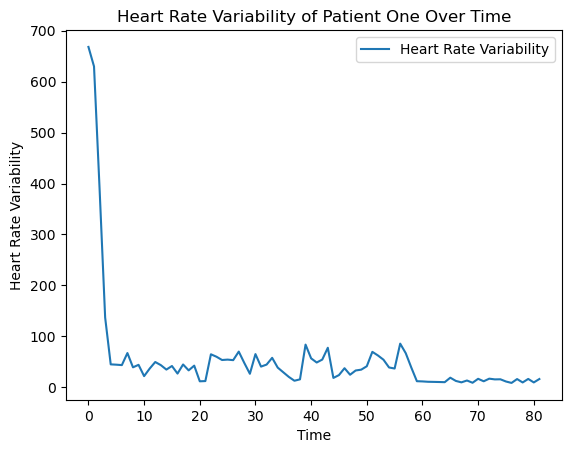

In [23]:
# visualize the time series
plt.plot(df_patient_hr['SDNN_10min'], label='Heart Rate Variability')
plt.xlabel('Time')
plt.ylabel('Heart Rate Variability')
plt.legend()
plt.title('Heart Rate Variability of Patient One Over Time')
plt.show();

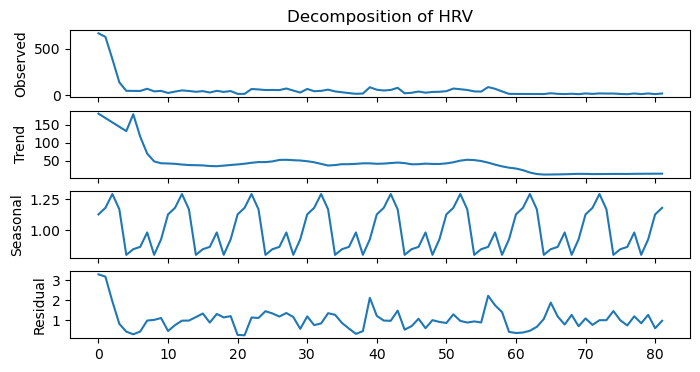

In [24]:
# checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
decomp1 = seasonal_decompose(df_patient_hr['SDNN_10min'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

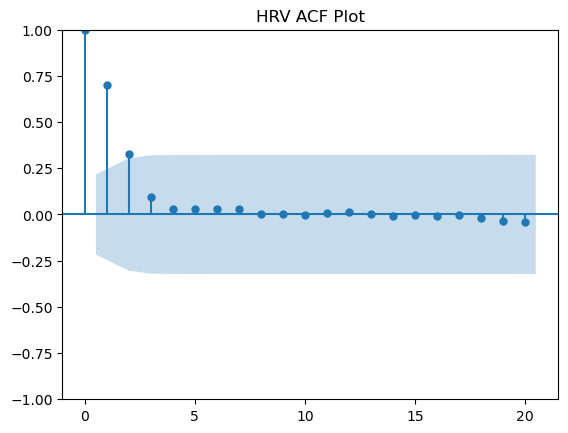

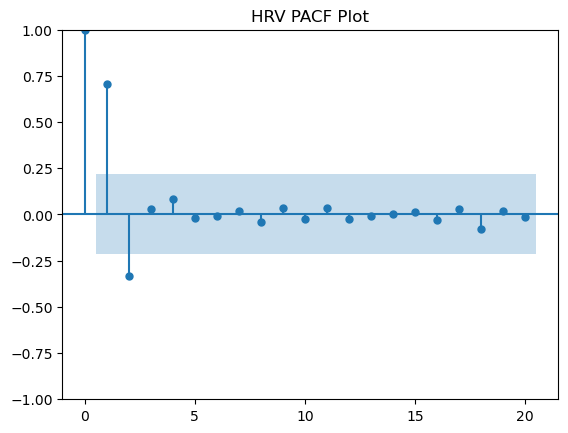

In [25]:
# plot of original dataset

# Autocorrelation Function
# This is used to determine the appropriate lag

series = df_patient_hr['SDNN_10min']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

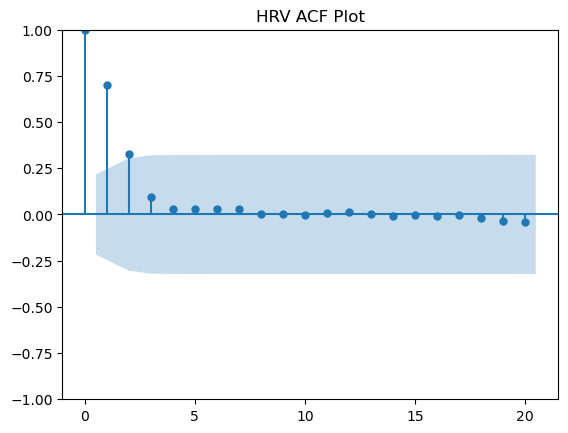

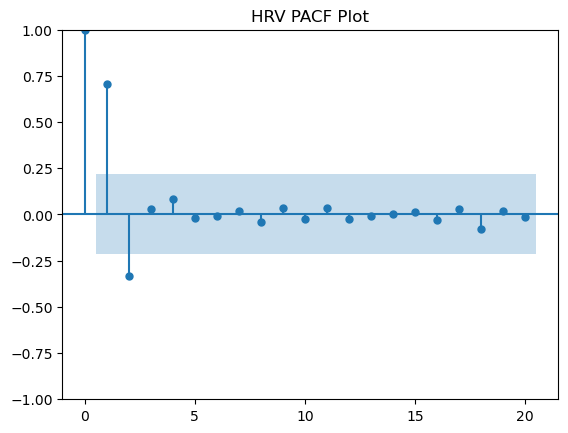

In [26]:
# Autocorrelation Function

series = df_patient_hr['SDNN_10min']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

- AR model may be slightly better. This in the partial autocorrelation plot, it doesn't drop immediately.

# AR Model

## Manually

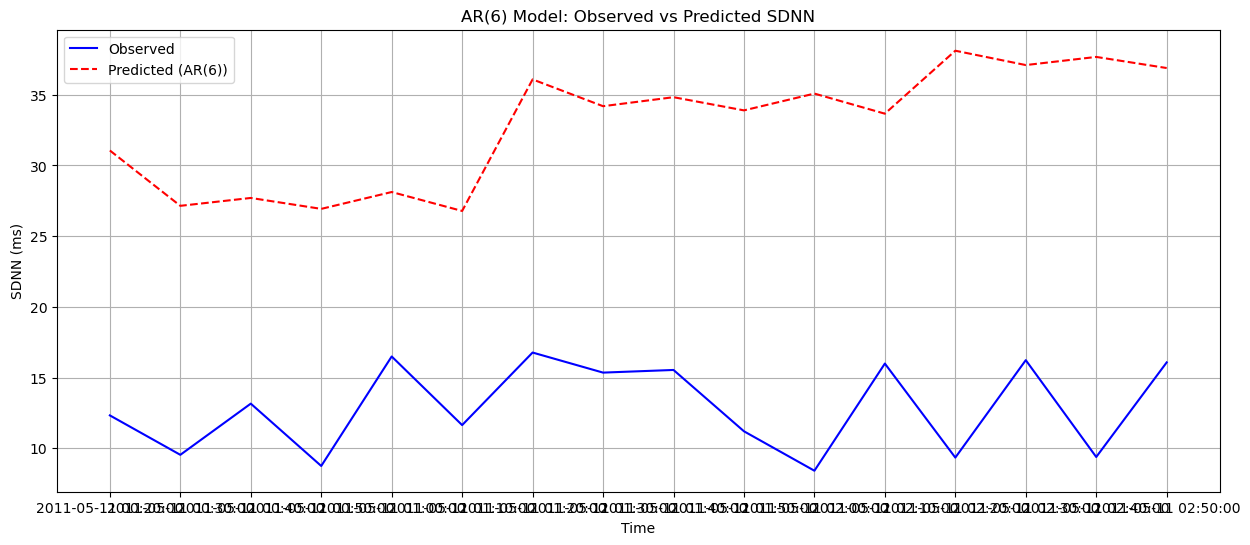

{'Model Coefficients': array([ 2.29171321e+01,  4.53961866e-01, -7.27377757e-02,  4.94051018e-02,
        -4.15026138e-02,  2.38012659e-02,  4.65649267e-03]),
 'Root Magnitudes': array([0.56472494, 0.49959376, 0.49959376, 0.47295447, 0.47295447,
        0.14768938])}

In [27]:
import numpy as np

# Work on the SDNN_10min data
df = df_patient_hr.copy()
df.set_index('timestamp', inplace=True)

# Choose lag
lag = 6

# Create lag features
for i in range(1, lag + 1):
    df[f'Lag {i}'] = df['SDNN_10min'].shift(i)

# Drop missing values created by lagging
df = df.dropna()

# Split into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Prepare y and X matrices
y_train = np.array(train_data['SDNN_10min']).reshape(-1, 1)
y_test = np.array(test_data['SDNN_10min']).reshape(-1, 1)

X_train = train_data.drop(columns=['SDNN_10min'])
X_train = np.column_stack((np.ones(len(X_train)), X_train))  # Add intercept

# Fit AR model using OLS
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))

# Define function to find AR roots
def find_ar_roots(ar_coeffs):
    ar_coeffs_1d = ar_coeffs.flatten() if ar_coeffs.ndim > 1 else ar_coeffs
    poly_coeffs = np.concatenate([[1], -1 * ar_coeffs_1d])
    roots = np.roots(poly_coeffs)
    return np.abs(roots)

# Extract AR coefficients (excluding intercept) and compute roots
ar_coeffs = w[1:]
roots = find_ar_roots(ar_coeffs)

# Initialize prediction loop
y_pred = []
last_vals = np.array(train_data['SDNN_10min'].iloc[-lag:].values[::-1])
last_vals_with_const = np.concatenate([[1], last_vals])

for _ in range(len(y_test)):
    next_val = np.dot(last_vals_with_const, w)
    y_pred.append(next_val[0])  # flatten result
    last_vals = np.roll(last_vals, -1)
    last_vals[-1] = next_val
    last_vals_with_const = np.concatenate([[1], last_vals])

# Create prediction DataFrame for plotting
pred_data = pd.DataFrame({'Time': test_data.index, 'pred_HRV': y_pred})
pred_data.set_index('Time', inplace=True)

# Save roots and coefficients for reference
model_summary = {
    "Model Coefficients": w.flatten(),
    "Root Magnitudes": roots
}

# Plot observed vs predicted
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['SDNN_10min'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred_HRV'], 'r--', label=f'Predicted (AR({lag}))')
plt.legend()
plt.title(f'AR({lag}) Model: Observed vs Predicted SDNN')
plt.xlabel('Time')
plt.ylabel('SDNN (ms)')
plt.grid(True)
plt.show()

model_summary


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE between predicted and true values
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

{"MAE": mae, "RMSE": rmse}


{'MAE': 19.946662528774564, 'RMSE': 20.47357600244531}

# MA model

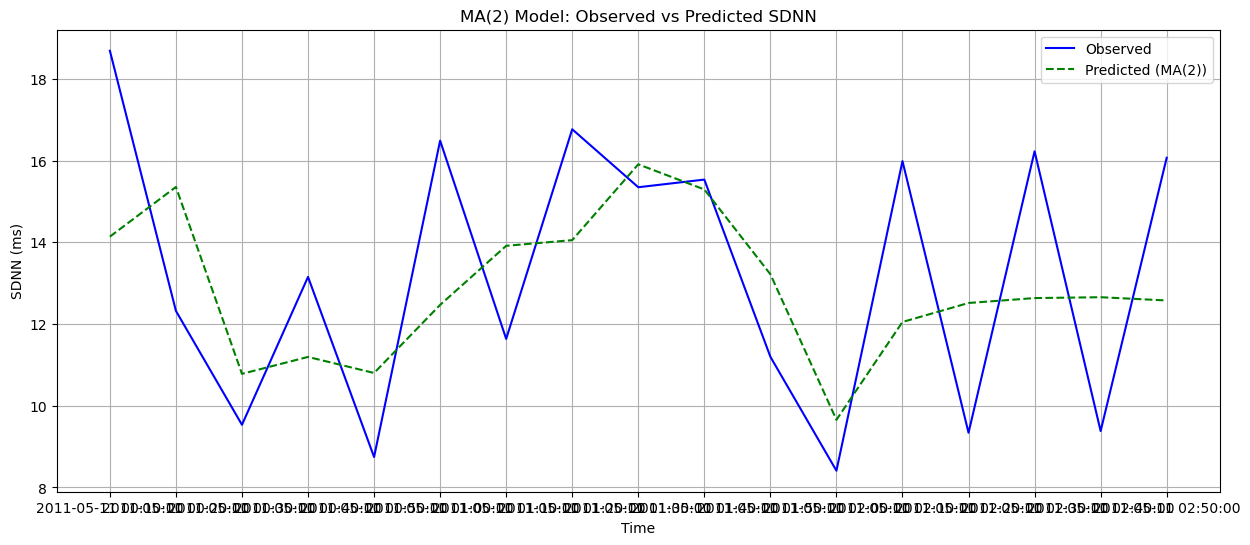

MAE: 2.55
RMSE: 2.83


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make sure your SDNN data is loaded and named correctly
df_ma = df_patient_hr.copy()
df_ma.set_index('timestamp', inplace=True)

# Choose MA lag (order q)
q = 2

# Compute rolling mean and residuals
df_ma['rolling_mean'] = df_ma['SDNN_10min'].rolling(window=q).mean()
df_ma['residual'] = df_ma['SDNN_10min'] - df_ma['rolling_mean']

# Drop initial rows with NaN due to rolling window
df_ma = df_ma.dropna()

# Split into training and testing sets
train_size = int(0.8 * len(df_ma))
train_data = df_ma.iloc[:train_size]
test_data = df_ma.iloc[train_size:]

# Initialize predictions list
ma_predictions = []

# Use past q residuals to predict SDNN
for i in range(len(test_data)):
    if i < q:
        past_residuals = np.concatenate([
            train_data['residual'].iloc[-(q - i):].values,
            (np.array(ma_predictions[:i]) - test_data['rolling_mean'].iloc[:i].values)
        ])
    else:
        past_residuals = np.array(ma_predictions[i - q:i]) - test_data['rolling_mean'].iloc[i - q:i].values

    predicted_residual = np.mean(past_residuals)
    predicted_value = test_data['rolling_mean'].iloc[i] + predicted_residual
    ma_predictions.append(predicted_value)

# Convert to arrays and remove any NaNs
y_true_ma = test_data['SDNN_10min'].values
y_pred_ma = np.array(ma_predictions)

valid_mask = ~np.isnan(y_true_ma) & ~np.isnan(y_pred_ma)
y_true_clean = y_true_ma[valid_mask]
y_pred_clean = y_pred_ma[valid_mask]

# Compute error metrics
mae = mean_absolute_error(y_true_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, y_true_ma, 'b-', label='Observed')
plt.plot(test_data.index, y_pred_ma, 'g--', label=f'Predicted (MA({q}))')
plt.legend()
plt.title(f'MA({q}) Model: Observed vs Predicted SDNN')
plt.xlabel('Time')
plt.ylabel('SDNN (ms)')
plt.grid(True)
plt.show()

# Print metrics
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
